In [1]:
import os
import numpy as np

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [2]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [3]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [4]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 50s 98ms/step - loss: 0.3357 - val_loss: 0.2774
Epoch 2/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2910 - val_loss: 0.2736
Epoch 3/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2853 - val_loss: 0.2681
Epoch 4/20
500/500 [==============================] - 50s 101ms/step - loss: 0.2820 - val_loss: 0.2694
Epoch 5/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2756 - val_loss: 0.2687
Epoch 6/20
500/500 [==============================] - 48s 96ms/step - loss: 0.2740 - val_loss: 0.2629
Epoch 7/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2716 - val_loss: 0.2626
Epoch 8/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2697 - val_loss: 0.2640
Epoch 9/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2658 - val_loss: 0.2624
Epoch 10/20
500/500 [==============================] - 46s 91ms/step - loss: 0.

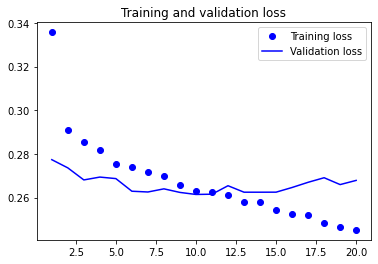

In [6]:
plot_loss(history)

In [7]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 96ms/step - loss: 0.3046 - val_loss: 0.2740
Epoch 2/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2877 - val_loss: 0.2705
Epoch 3/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2806 - val_loss: 0.2636
Epoch 4/20
500/500 [==============================] - 47s 93ms/step - loss: 0.2763 - val_loss: 0.2622
Epoch 5/20
500/500 [==============================] - 46s 93ms/step - loss: 0.2737 - val_loss: 0.2646
Epoch 6/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2673 - val_loss: 0.2618
Epoch 7/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2649 - val_loss: 0.2637
Epoch 8/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2632 - val_loss: 0.2613
Epoch 9/20
500/500 [==============================] - 46s 93ms/step - loss: 0.2591 - val_loss: 0.2715
Epoch 10/20
500/500 [==============================] - 47s 94ms/step - loss: 0.257

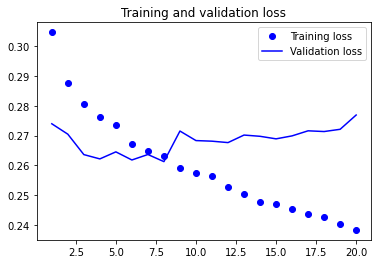

In [8]:
plot_loss(history)

In [9]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 49s 97ms/step - loss: 0.3131 - val_loss: 0.2779
Epoch 2/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2860 - val_loss: 0.2697
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2794 - val_loss: 0.2694
Epoch 4/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2770 - val_loss: 0.2640
Epoch 5/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2739 - val_loss: 0.2626
Epoch 6/20
500/500 [==============================] - 47s 93ms/step - loss: 0.2689 - val_loss: 0.2622
Epoch 7/20
500/500 [==============================] - 47s 93ms/step - loss: 0.2673 - val_loss: 0.2642
Epoch 8/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2663 - val_loss: 0.2613
Epoch 9/20
500/500 [==============================] - 47s 95ms/step - loss: 0.2648 - val_loss: 0.2661
Epoch 10/20
500/500 [==============================] - 48s 97ms/step - loss: 0.261

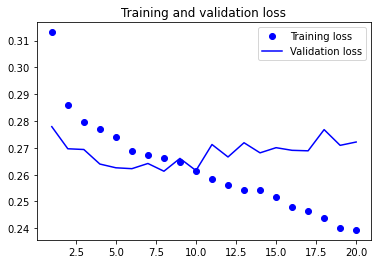

In [10]:
plot_loss(history)

In [11]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 53s 104ms/step - loss: 0.3065 - val_loss: 0.2750
Epoch 2/20
500/500 [==============================] - 51s 101ms/step - loss: 0.2832 - val_loss: 0.2709
Epoch 3/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2775 - val_loss: 0.2662
Epoch 4/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2736 - val_loss: 0.2681
Epoch 5/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2691 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2662 - val_loss: 0.2675
Epoch 7/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2629 - val_loss: 0.2684
Epoch 8/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2594 - val_loss: 0.2758
Epoch 9/20
500/500 [==============================] - 50s 101ms/step - loss: 0.2559 - val_loss: 0.2670
Epoch 10/20
500/500 [==============================] - 51s 102ms/step - loss

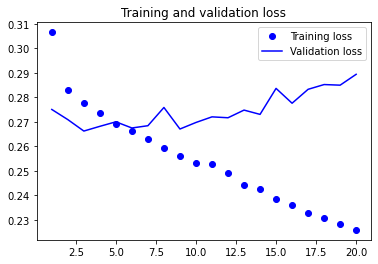

In [12]:
plot_loss(history)

In [13]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 55s 107ms/step - loss: 0.3063 - val_loss: 0.2770
Epoch 2/20
500/500 [==============================] - 53s 105ms/step - loss: 0.2859 - val_loss: 0.2732
Epoch 3/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2810 - val_loss: 0.2665
Epoch 4/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2784 - val_loss: 0.2664
Epoch 5/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2748 - val_loss: 0.2662
Epoch 6/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2711 - val_loss: 0.2696
Epoch 7/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2700 - val_loss: 0.2616
Epoch 8/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2662 - val_loss: 0.2676
Epoch 9/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2659 - val_loss: 0.2663
Epoch 10/20
500/500 [==============================] - 52s 105ms/step - l

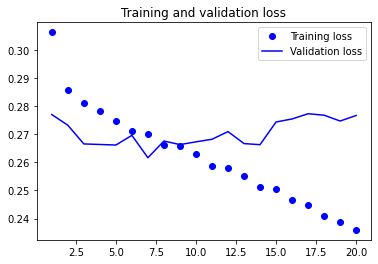

In [14]:
plot_loss(history)